## линейная регрессия с mlflow в задачах And Or Xor

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import Image, display
import pickle
import os.path
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore")

## Создание эксперимента в MLflow где будут храниться запуски

In [3]:
mlflow.sklearn.autolog()
experiment = mlflow.set_experiment("And_Or_Xor_linear_regr")

## Класс, генерирующий данные, описывающий архитектуру модели и обучающий ее

In [17]:
class LogicOperator:
    dict_of_alg_sk = {"LinearRegression": LinearRegression(),
                      "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, random_state=0),
                      "KNeighborsClassifier": KNeighborsClassifier(3)}

    def __init__(self, operator: str, alg: str) -> None:
        self.data = np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ])
        self.operator: str = operator
        self.alg: str = alg
        self.target: np.ndarray
        self.file_path_model: str = f"models\{alg}_{operator}.pkl"

        if not os.path.exists(self.file_path_model):
            self.save_model()
        elif not os.path.getsize(self.file_path_model) > 0:
            os.remove(self.file_path_model)
            self.save_model()

        self.ready_model = self.load_model()

    def create_model(self) -> ...:  # Type of return
        return self.dict_of_alg_sk[self.alg]

    def show_result(self) -> None:

        y_pred = self.ready_model.predict(self.data)
        plt.subplot(1, 2, 1)
        plt.title('PREDICTED')
        for x, y in zip(self.data, y_pred):
            if y > 0.5:
                plt.scatter(x[0], x[1], c='r')
            elif y < 0.5:
                plt.scatter(x[0], x[1], c='g')
        plt.subplot(1, 2, 2)
        plt.title('TARGET')

        for x, y in zip(self.data, self.generate_target()):
            if y > 0.5:
                plt.scatter(x[0], x[1], c='r')
            elif y < 0.5:
                plt.scatter(x[0], x[1], c='g')

        plt.show()

    def get_pred(self):
        model = self.load_model()
        return model.predict(self.data)

    def load_model(self):
        if os.path.getsize(self.file_path_model) > 0:
            with open(self.file_path_model, "rb") as f:
                unpickler = pickle.Unpickler(f)
                model = unpickler.load()
                return model

    def generate_target(self) -> ...:
        if self.operator == 'and':
            self.target = np.array([[x1 and x2] for [x1, x2] in self.data])
        elif self.operator == 'or':
            self.target = np.array([[x1 or x2] for [x1, x2] in self.data])
        else:
            self.target = np.array([[int(not x1 and x2) or int(not x2 and x1)] for [x1, x2] in self.data])
        return self.target

    def fit_model_sk(self) -> ...:
        y = self.generate_target()
        model = self.create_model().fit(self.data, y)
        return model

    def save_model(self) -> None:
        with open(self.file_path_model, 'wb') as f:
            model = self.fit_model_sk()
            pickle.dump(model, f)

    def get_result(self):
        return self.ready_model, self.data, self.ready_model.predict(self.data) 

## Функция для отображения разделяющей гиперплоскости

In [26]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)

    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)

    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([-0.25, 0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.show()

## Эксперимент, предсказывающий функцию XOR при помощи линейной регрессии, белая плоскость обусловлена тем, что предсказание на любой выборке будет 0,5

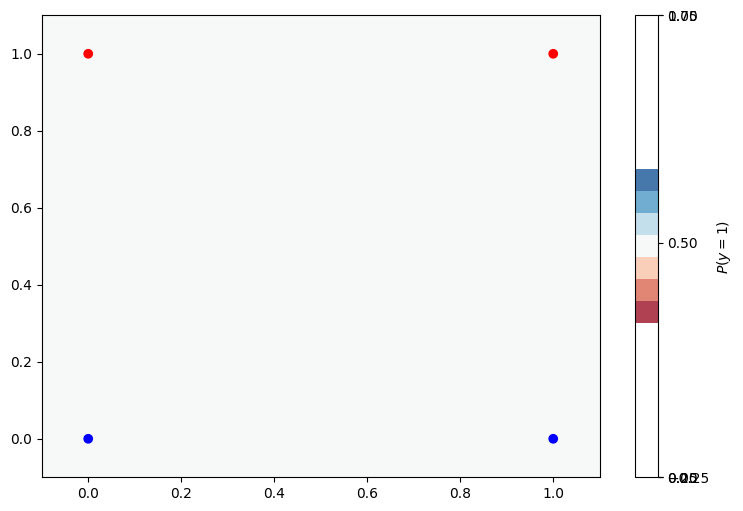

In [35]:
cl = LogicOperator('xor', 'LinearRegression')
model, data, predictions = cl.get_result()
plot_decision_boundary(model.predict, data, np.round(predictions))

## Эксперимент предсказания функции OR

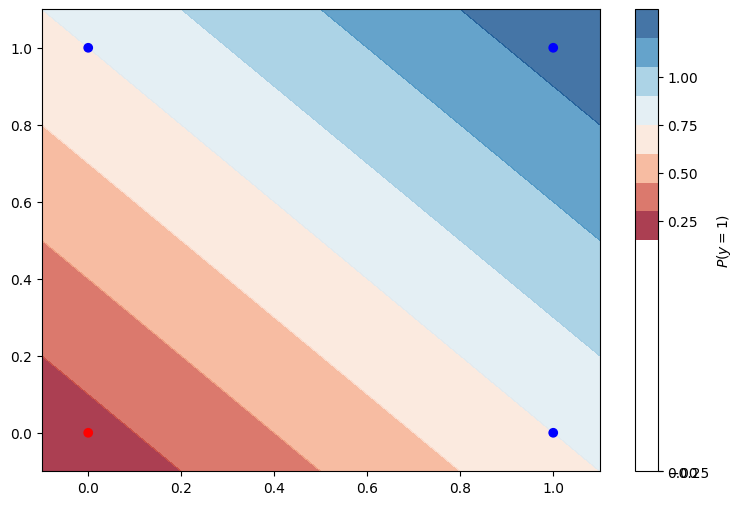

In [33]:
cl1 = LogicOperator('or', 'LinearRegression')
model, data, predictions = cl1.get_result()
plot_decision_boundary(model.predict, data, np.round(predictions))

## Эксперимент предсказания функции AND

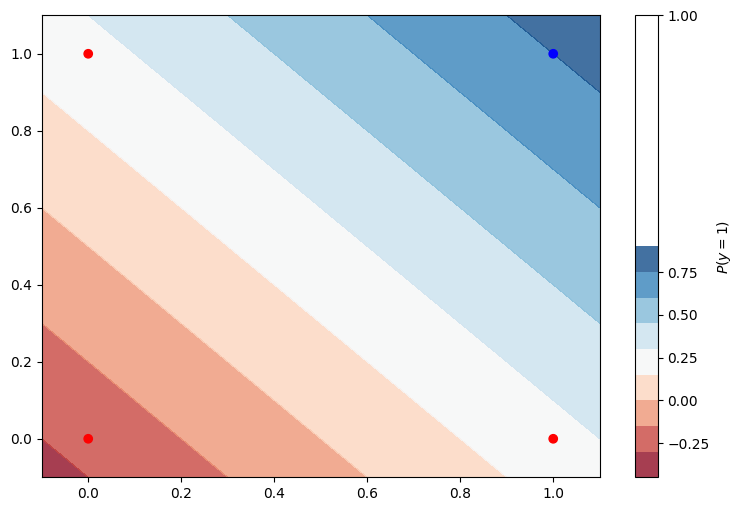

In [34]:
cl1 = LogicOperator('and', 'LinearRegression')
model, data, predictions = cl1.get_result()
plot_decision_boundary(model.predict, data, np.round(predictions))

## Регистрация полученных артифактов модели в MLFLOW

In [36]:
list_of_model = ['LinearRegression', 'AdaBoostClassifier', 'KNeighborsClassifier']
lin_reg = list_of_model[0]
list_of_operation = ['and', 'or', 'xor']

for op in list_of_operation:
    with mlflow.start_run(run_name="and_or_xor") as run:
        l1 = LogicOperator(op, lin_reg)
        model = l1.load_model()
        data = l1.data
        target = l1.generate_target()
        signature = infer_signature(data, model.predict(data))
        mlflow.sklearn.log_model(model, "model", signature=signature)
        model_uri = mlflow.get_artifact_uri("model")


## Поиск в реестре моделей MLFLOW наилучших запусков

In [11]:
import pprint

from mlflow.entities import ViewType
import mlflow
from mlflow import MlflowClient

run = MlflowClient().search_runs(
    experiment_ids='332795901300589432',
    order_by=["metrics.training_mean_absolute_error"],
)

for run1 in run:
    logged_model = f'runs:/{run1.info.run_id}/model'
    loaded_model = mlflow.pyfunc.load_model(logged_model)
    data: np.ndarray = np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ], dtype='f')
    target = loaded_model.predict(data)
    


[[0.25]
 [0.75]
 [0.75]
 [1.25]]
[[-0.25]
 [ 0.25]
 [ 0.25]
 [ 0.75]]
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
